In [1]:
import numpy as np
import matplotlib.pyplot as plt
from warnings import warn

# за пределами нейронки будут находиться основные функции - функция потерь, активации и регуляризация, 
# последнее можно было бы не выносить, но раз уж выносим все, то почему бы и нет
# все функции кроме основной задачи должны выполнять и расчет своей производной как простой функции

# слегка переписанный softmax, теперь он считает только значения loss функции и производную этой же функции
def softmaxLoss(score, Y):
    
    loss = 0.0
    
    grad = np.zeros_like(score)
    
    grad = np.exp(score) / np.sum(np.exp(score), axis=1, keepdims=True)
    loss = np.mean(-np.log(grad[np.arange(score.shape[0]),Y]))
    
    # mean(Si - dyi)
    grad[np.arange(score.shape[0]),Y]-=1
    grad/=score.shape[0]
    
    return loss, grad

# регуляризация и производная
def L2reg(W, reg):
    
    loss = 0.0
    grad = np.zeros_like(W)
    
    loss = reg * np.sum(W * W)
    grad = 2*reg*W
    
    return loss, grad
    
# функция активации с подсчетом своей производной
def ReLU(x):
    return np.maximum(x, 0), (x>0).astype(int)
    
class CasualNetwork(object):
    
    def __init__(self, lgFunc=softmaxLoss, rgFunc=L2reg):
        self.W = {}
        self.b = {}
        self.agFuncs = {}
        self.lgFunc=lgFunc
        self.rgFunc=rgFunc
        
        self.gradA = {}
        self.a = {}
        
        self.dW = {}
        self.db = {}
        
    def addLayer(self, outputSize, inputSize=None, std=1e-1, agFunc=lambda x:(x, 1)):
        
        # немного проверок
        if len(self.W) == 0 and inputSize == None:
            raise Exception("inputSize was't define")
            
        if len(self.W) > 0 and inputSize != self.W[len(self.W)-1].shape[1]:
            warn("inputSize was ignored", RuntimeWarning)
            inputSize = self.W[len(self.W)-1].shape[1]

        self.W[len(self.W)] = std * np.random.randn(inputSize, outputSize)
        self.b[len(self.b)] = np.zeros((1, outputSize))
        self.agFuncs[len(self.agFuncs)] = agFunc
        
    def train(self, X, Y, Xtest, Ytest,
              learningRate=1e-3, learningDecay=0.95,
              reg=5e-6, numIters=100,
              batchSize=200, verbose=False):
        
        lossHistory = []
        trainAccHistory = []
        testAccHistory = []
        
        itPerEpoch = max(int(X.shape[0] / batchSize), 1)
        
        for it in range(numIters):
            
            indexs = np.random.choice(X.shape[0], batchSize)
            
            batchX = X[indexs]
            batchY = Y[indexs]
            
            self._forward(batchX)
            
            loss = sum(self._backward(batchY, reg))
            
            lossHistory.append(loss)
            
            for l in range(len(self.W)):
                self.W[l] -= learningRate*self.dW[l]
                self.b[l] -= learningRate*self.db[l]
                
            if it % itPerEpoch == 0:
                
                if verbose:
                    print('iteration %d / %d: loss %f' % (it, numIters, loss))
                
                trainAcc = (self.predict(batchX) == batchY).mean()
                testAcc = (self.predict(Xtest) == Ytest).mean()
                trainAccHistory.append(trainAcc)
                testAccHistory.append(testAcc)

                learningRate *= learningDecay
                
        return lossHistory, trainAccHistory, testAccHistory

    def predict(self, X):
        return np.argmax(self._forward(X), axis=1)
    
    def _reset(self, std=0.1):
        for l in range(len(self.W)):
            self.W[l] = std * np.random.randn(*self.W[l].shape)
            self.b[l] = np.zeros_like(self.b[l])
        
    def _forward(self, X):
        # X@W + b
        
        self.a[-1] = X
        
        for l in range(len(self.W)):
            self.a[l] = self.a[l-1]@self.W[l] + self.b[l]
            self.a[l], self.gradA[l] = self.agFuncs[l](self.a[l])
        
        return self.a[len(self.W)-1]
    
    
    def _backward(self, Y, reg):
        
        loss = 0.0
        regLoss = 0.0
        
        # dloss - previous step gradient 
        loss, dloss = self.lgFunc(self.a[len(self.W)-1], Y)
    
        for l in range(len(self.W)-1, -1, -1):
            # учитываем производную функции активации
            dloss *= self.gradA[l]
            # производная по dW домножается на X или точнее результат работы прошлого слоя
            bufLoss, dreg = self.rgFunc(self.W[l], reg)
            self.dW[l] = self.a[l-1].T@dloss + dreg
            regLoss += bufLoss
            # производная по db должна домножаться на вектор единиц, то есть просто сумма
            self.db[l] = np.sum(dloss, axis=0, keepdims=True)
            dloss = dloss@self.W[l].T
        
        return loss, regLoss

In [2]:
input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

# тест модели из методички, немного переделан под мой класс
def init_toy_model():
    net = CasualNetwork()
    np.random.seed(0)
    net.addLayer(hidden_size,input_size,agFunc=ReLU, std=1e-1)
    net.addLayer(num_classes,hidden_size, std=1e-1)
    return net

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

In [3]:
scores = net._forward(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print(correct_scores)
print()


print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.680272087688147e-08


In [4]:
# мой лосс разделен на 2, по этому берем сумму для проверки
loss, regLoss = net._backward(y, reg=0.05)
correct_loss = 1.30378789133

print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss + regLoss - correct_loss)))

Difference between your loss and correct loss:
1.794120407794253e-13


In [5]:
# проверяем расчет производных
# чтобы кусок блокнота мыожно было перезапускать востановим данные
net._forward(X)
net._backward(y, reg=0.05)

# функция из методички
def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
    fx = f(x) # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h) # the slope
        if verbose:
            print(ix, grad[ix])
        it.iternext() # step to next dimension

    return grad

# функция из методички
def rel_error(x, y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

dW = net.dW.copy()
db = net.db.copy()

W = net.W.copy()
b = net.b.copy()

def decorDw(W, num, X, y, reg):
    net.W[num] = W.copy()
    net._forward(X)
    return sum(net._backward(y, reg))

def decorDb(b, num, X, y, reg):
    net.b[num] = b.copy()
    net._forward(X)
    return sum(net._backward(y, reg))

# между делом, код из методички, на этом же шаге, делает вообще не то, что должен, но об этом подробнее при сдаче
for i in range(len(W)):
    f = lambda W: decorDw(W, i, X, y, reg=0.05)
    param_grad_num = eval_numerical_gradient(f, W[i].copy(), verbose=False)
    # востановим старые данные для следующего цикла
    net.W = W.copy()
    net.b = b.copy()
    print('dW%s max relative error: %e' % (i+1, rel_error(param_grad_num, dW[i])))
    
for i in range(len(b)):
    f = lambda b: decorDb(b, i, X, y, reg=0.05)
    param_grad_num = eval_numerical_gradient(f, b[i].copy(), verbose=False)
    # востановим старые данные
    net.W = W.copy()
    net.b = b.copy()
    print('db%s max relative error: %e' % (i+1, rel_error(param_grad_num, db[i])))

# востановим старые данные
_ = net._forward(X)
_ = net._backward(y, reg=0.05)

dW1 max relative error: 3.669858e-09
dW2 max relative error: 3.440708e-09
db1 max relative error: 2.738421e-09
db2 max relative error: 4.447677e-11


Final training loss:  0.01714960793873202


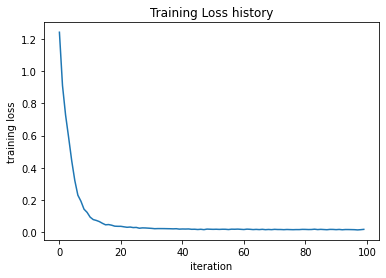

In [6]:
# Тест модели из методички
net = init_toy_model()

stats = net.train(X, y, X, y,
            learningRate=1e-1, reg=5e-6,
            numIters=100, verbose=False)

print('Final training loss: ', stats[0][-1])


plt.plot(stats[0])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

In [7]:
from sklearn.datasets import load_digits

digits = load_digits()

# данные из первой лабы + разделение на test train
X = np.array(digits['data'])
Y = np.array(digits['target'])

p = np.random.RandomState(seed=123).permutation(len(X))

X = X[p]
Y = Y[p]

Xtrain = X[:int(len(X)*0.75)]
Xtest = X[int(len(X)*0.75):]
Ytrain = Y[:int(len(X)*0.75)]
Ytest = Y[int(len(X)*0.75):]

mean = np.mean(Xtrain, axis=0)

Xtrain -= mean
Xtest -= mean

print(len(Xtrain), len(Xtest), len(X))

1347 450 1797


Train accuracy: 0.33 Test accuracy: 0.2577777777777778


<ipython-input-1-7bda62405660>:62: RuntimeWarning: inputSize was ignored
  warn("inputSize was ignored", RuntimeWarning)


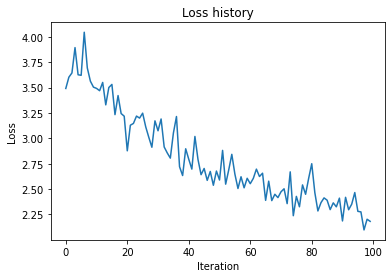

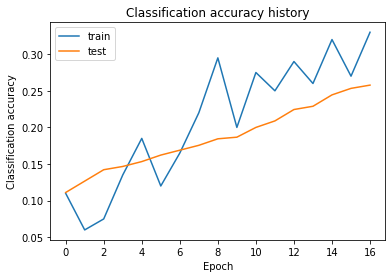

In [8]:
# ну попробуем для начала размерность скрытого слоя 64(по одному на каждый пиксель)
# параметры по умолчанию
# warning вызван моим кодом, нет проблем
def plotAll(stats):
    print('Train accuracy: '+str(stats[1][-1])+" Test accuracy: "+str(stats[2][-1]))
    plt.plot(stats[0])
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.show()
    
    plt.plot(stats[1], label='train')
    plt.plot(stats[2], label='test')
    plt.title('Classification accuracy history')
    plt.xlabel('Epoch')
    plt.ylabel('Classification accuracy')
    plt.legend()
    plt.show()
    
net = CasualNetwork()
net.addLayer(64,Xtrain.shape[1],agFunc=ReLU)
net.addLayer(10)

stats = net.train(Xtrain, Ytrain, Xtest, Ytest)

plotAll(stats)

Train accuracy: 0.99 Test accuracy: 0.9777777777777777


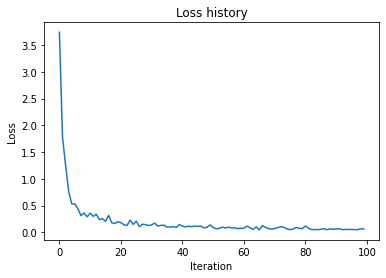

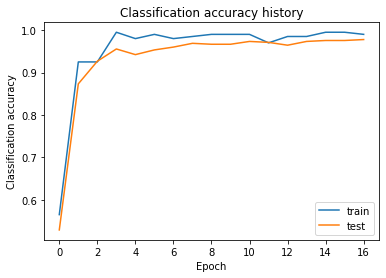

In [9]:
# по ощущениям мы не доучились увеличим этот параметр
# около 99/97 точности на разных выборках, в целом можно сказать что это хороший результат,
# попробую еще поиграть с регуляризацией, чтобы быть более устойчивым к переобучению

net._reset()

stats = net.train(Xtrain, Ytrain, Xtest, Ytest, learningRate=1e-1)

plotAll(stats)

Train accuracy: 0.98 Test accuracy: 0.9711111111111111


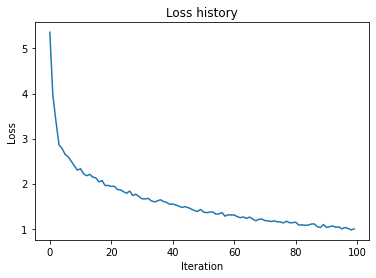

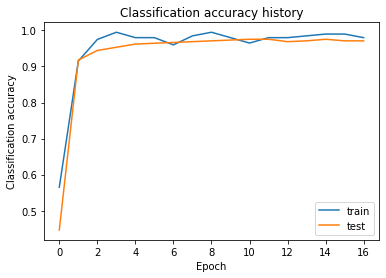

In [10]:
# теперь примерно 98/97 на разных выборках, думаю так лучше, меньше переобучаемся
net._reset()

stats = net.train(Xtrain, Ytrain, Xtest, Ytest, learningRate=1e-1, reg=0.05)

plotAll(stats)

<ipython-input-1-7bda62405660>:62: RuntimeWarning: inputSize was ignored
  warn("inputSize was ignored", RuntimeWarning)


Train accuracy: 0.98 Test accuracy: 0.9666666666666667


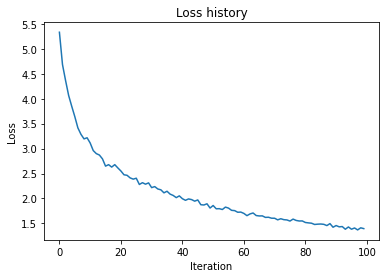

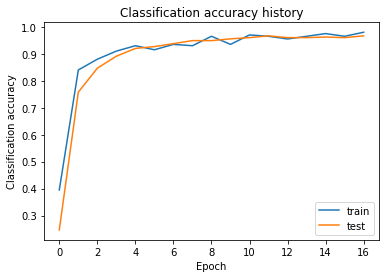

In [11]:
# ну и напоследок попробую накинуть еще 1 слой, посмотрим что выйдет, изменять его функцию активации мне лень, так что оставлю ту же самую, а вот размерность уменьшим скажем до 16, просто так
# около 98/95 на разных выборках, сложно сказать точно, но думаю, что и 2 слоев хватает 
net = CasualNetwork()
net.addLayer(64,Xtrain.shape[1],agFunc=ReLU)
net.addLayer(16)
net.addLayer(10)

stats = net.train(Xtrain, Ytrain, Xtest, Ytest, learningRate=1e-1, reg=0.05)

plotAll(stats)